In [ ]:
!pip install tensorflow tensorflow_datasets

In [ ]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
dataset, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True)

print(dataset)
print(info)

# Split the dataset
train = dataset['train']
test = dataset['test']

# Define the split for training and validation
split_percentage = 0.9
train_size = int(split_percentage * info.splits['train'].num_examples)
val_size = info.splits['train'].num_examples - train_size

# Use the 'train_test_split' function from tf.data.experimental
train_data = train.take(train_size)
valid_data = train.skip(train_size)
test_data = test

# Print dataset sizes
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {info.splits['test'].num_examples}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete8GSE4P/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete8GSE4P/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir=PosixGPath('/tmp/tmp8q4hla9gtfds'),
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes

In [ ]:
print(train_data)
print(valid_data)
print(test_data)

<_TakeDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
import matplotlib.pyplot as plt


def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(4):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = info.features['label'].int2str(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

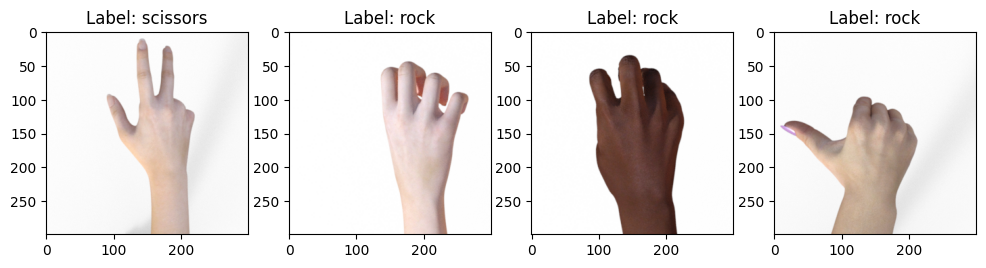

In [ ]:
preview_dataset(valid_data)

In [ ]:
#def preprocess(image, label):
#    image = tf.image.resize(image, (180, 180))
#    image = image / 255.0  # Normalize to [0,1] range
#    print(image)
#    return image, label

train_ds = train_data.shuffle(100).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_data.shuffle(100).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_data.shuffle(100).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
print(train_ds)
print(valid_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
for image_batch, label_batch in valid_ds.take(1):
  pass

print(image_batch.shape)
print(label_batch)

(32, 300, 300, 3)
tf.Tensor([2 1 1 2 1 0 2 2 2 0 1 0 2 0 2 0 0 2 0 1 2 0 2 0 0 1 2 0 0 2 2 0], shape=(32,), dtype=int64)


In [ ]:
print(len(train_ds))
print(len(valid_ds))

71
8


## lr = 1e-5

### 모델 구현

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_100epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/100
71/71 [==============================] - 63s 540ms/step - loss: 65.6708 - accuracy: 0.3289 - val_loss: 4.2110 - val_accuracy: 0.3214
Epoch 2/100
71/71 [==============================] - 27s 383ms/step - loss: 52.7698 - accuracy: 0.3144 - val_loss: 2.9545 - val_accuracy: 0.3254
Epoch 3/100
71/71 [==============================] - 28s 393ms/step - loss: 46.0876 - accuracy: 0.3157 - val_loss: 2.2843 - val_accuracy: 0.3214
Epoch 4/100
71/71 [==============================] - 29s 403ms/step - loss: 34.5732 - accuracy: 0.3430 - val_loss: 1.1768 - val_accuracy: 0.4563
Epoch 5/100
71/71 [==============================] - 24s 336ms/step - loss: 28.8710 - accuracy: 0.3629 - val_loss: 2.6900 - val_accuracy: 0.3214
Epoch 6/100
71/71 [==============================] - 23s 330ms/step - loss: 26.0045 - accuracy: 0.3382 - val_loss: 2.5933 - val_accuracy: 0.3452
Epoch 7/100
71/71 [==============================] - 23s 328ms/step - loss: 22.2751 - accuracy: 0.3064 - val_loss: 2.2832 - val_ac

### Train, Validation Accuracy, Loss

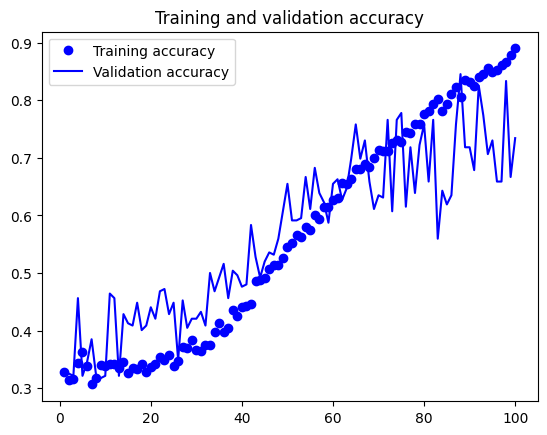

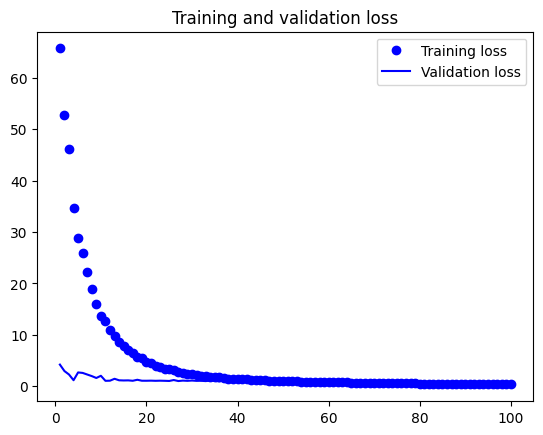

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Testset Evaluation

In [ ]:
test_model = keras.models.load_model('xception_100epch')
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test Accuracy : {test_acc}, Test Loss : {test_loss}")

12/12 [==============================] - 3s 239ms/step - loss: 2.7479 - accuracy: 0.5403
Test Accuracy : 0.5403226017951965, Test Loss : 2.74790358543396


## lr = 1e-4

### 모델 구현

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_100epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/100
71/71 [==============================] - 68s 625ms/step - loss: 46.6584 - accuracy: 0.3272 - val_loss: 8.0865 - val_accuracy: 0.3214
Epoch 2/100
71/71 [==============================] - 27s 384ms/step - loss: 10.2606 - accuracy: 0.3302 - val_loss: 1.3012 - val_accuracy: 0.3095
Epoch 3/100
71/71 [==============================] - 23s 318ms/step - loss: 4.5708 - accuracy: 0.3369 - val_loss: 1.8112 - val_accuracy: 0.3889
Epoch 4/100
71/71 [==============================] - 28s 399ms/step - loss: 2.7762 - accuracy: 0.3576 - val_loss: 1.2353 - val_accuracy: 0.4167
Epoch 5/100
71/71 [==============================] - 28s 398ms/step - loss: 1.7548 - accuracy: 0.4065 - val_loss: 1.1981 - val_accuracy: 0.4325
Epoch 6/100
71/71 [==============================] - 23s 329ms/step - loss: 1.3796 - accuracy: 0.4471 - val_loss: 1.5138 - val_accuracy: 0.3373
Epoch 7/100
71/71 [==============================] - 28s 394ms/step - loss: 1.1494 - accuracy: 0.5322 - val_loss: 1.0631 - val_accurac

### Train, Validation Accuracy, Loss

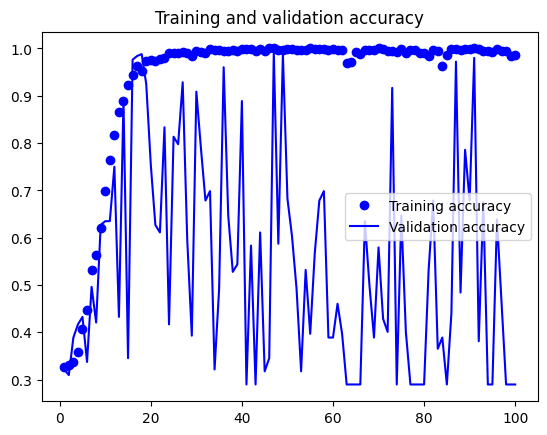

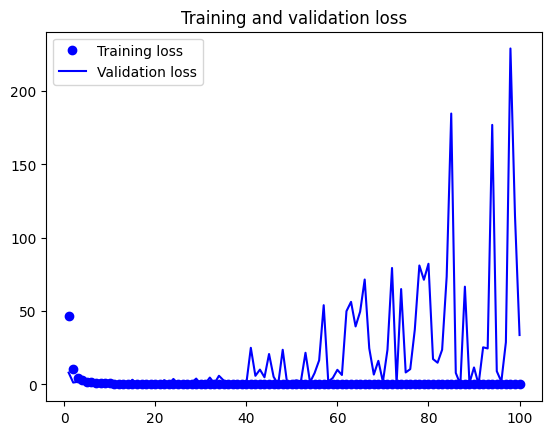

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Testset Evaluation

12/12 [==============================] - 3s 239ms/step - loss: 4.9012 - accuracy: 0.7285
Evaluation Time: 5.418494939804077 seconds
Test Accuracy: 0.7284946441650391
Test Loss: 4.901182651519775


(0.0, 6.418494939804077)

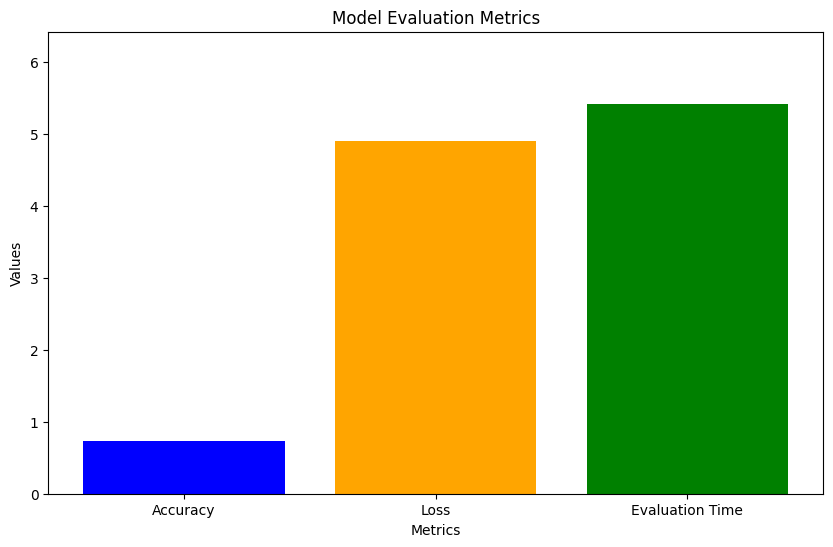

In [ ]:
import time
import matplotlib.pyplot as plt
from tensorflow import keras

test_model = keras.models.load_model('xception_100epch')
start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_ds)
end_time = time.time()
eval_time = end_time - start_time

print(f"Evaluation Time: {eval_time} seconds")
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

#그래프 그리기
metrics = ['Accuracy', 'Loss', 'Evaluation Time']
values = [test_acc, test_loss, eval_time]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.ylim(0, max(values) + 1)  # Adjust


## lr = 5e-5

### 모델 구현

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=5e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_100epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/100
71/71 [==============================] - 35s 403ms/step - loss: 35.2946 - accuracy: 0.3461 - val_loss: 7.9892 - val_accuracy: 0.3214
Epoch 2/100
71/71 [==============================] - 28s 390ms/step - loss: 13.8227 - accuracy: 0.3333 - val_loss: 2.4207 - val_accuracy: 0.2897
Epoch 3/100
71/71 [==============================] - 29s 404ms/step - loss: 6.8422 - accuracy: 0.3280 - val_loss: 1.1535 - val_accuracy: 0.2897
Epoch 4/100
71/71 [==============================] - 24s 333ms/step - loss: 4.1898 - accuracy: 0.3294 - val_loss: 1.4668 - val_accuracy: 0.3889
Epoch 5/100
71/71 [==============================] - 27s 387ms/step - loss: 2.8477 - accuracy: 0.3373 - val_loss: 1.1516 - val_accuracy: 0.3651
Epoch 6/100
71/71 [==============================] - 28s 393ms/step - loss: 2.0986 - accuracy: 0.3783 - val_loss: 1.0864 - val_accuracy: 0.4325
Epoch 7/100
71/71 [==============================] - 28s 396ms/step - loss: 1.7343 - accuracy: 0.3973 - val_loss: 1.0547 - val_accurac

### Train, Validation Accuracy, Loss

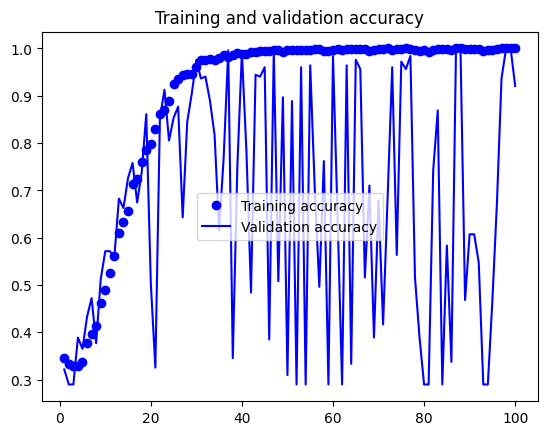

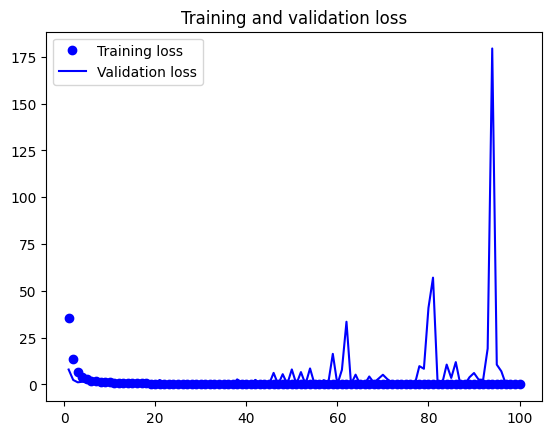

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Testset Evaluation

In [ ]:
test_model = keras.models.load_model('xception_100epch')
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test Accuracy : {test_acc}, Test Loss : {test_loss}")

12/12 [==============================] - 1s 80ms/step - loss: 4.0421 - accuracy: 0.6774
Test Accuracy : 0.6774193644523621, Test Loss : 4.04214334487915


## lr = 2e-5

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=2e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_100epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/100
71/71 [==============================] - 62s 544ms/step - loss: 28.8944 - accuracy: 0.3567 - val_loss: 3.3005 - val_accuracy: 0.3214
Epoch 2/100
71/71 [==============================] - 28s 394ms/step - loss: 17.9467 - accuracy: 0.3391 - val_loss: 2.8787 - val_accuracy: 0.3214
Epoch 3/100
71/71 [==============================] - 28s 390ms/step - loss: 11.9352 - accuracy: 0.3377 - val_loss: 1.1869 - val_accuracy: 0.2817
Epoch 4/100
71/71 [==============================] - 28s 398ms/step - loss: 8.3892 - accuracy: 0.3245 - val_loss: 1.1074 - val_accuracy: 0.3889
Epoch 5/100
71/71 [==============================] - 23s 324ms/step - loss: 6.3627 - accuracy: 0.3183 - val_loss: 1.6535 - val_accuracy: 0.3214
Epoch 6/100
71/71 [==============================] - 23s 326ms/step - loss: 4.7940 - accuracy: 0.3399 - val_loss: 1.2528 - val_accuracy: 0.2897
Epoch 7/100
71/71 [==============================] - 23s 327ms/step - loss: 3.6247 - accuracy: 0.3558 - val_loss: 1.2764 - val_accura

### Train, Validation Accuracy, Loss

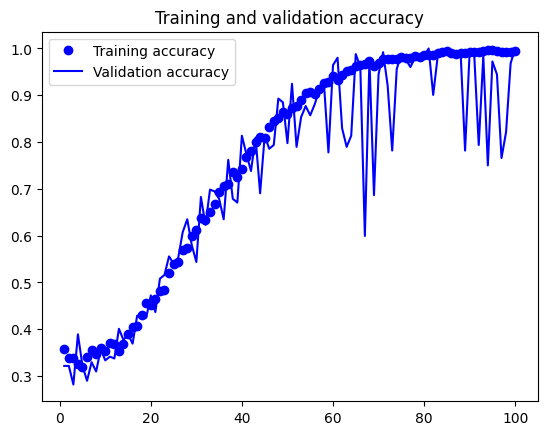

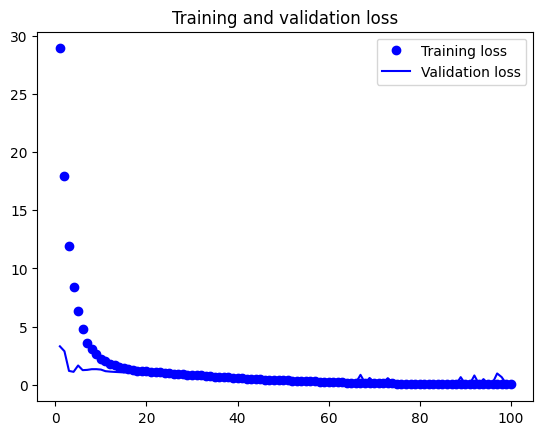

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Testset Evaluation

In [ ]:
test_model = keras.models.load_model('xception_100epch')
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test Accuracy : {test_acc}, Test Loss : {test_loss}")

12/12 [==============================] - 4s 267ms/step - loss: 4.2586 - accuracy: 0.6882
Test Accuracy : 0.6881720423698425, Test Loss : 4.25860071182251
